In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

In [2]:
h_bar = 1.0
m = 0.067

N = 300
L = 100.0 / 0.05292
dx = L / N
to_meV = 27211.6

In [3]:
# Funkcja do obliczania energii stanu kwantowego w punkcie i
@njit
def HPsi(psi_i, i, V):
    return -h_bar**2/(2*m) * (psi_i[i+1] + psi_i[i-1] - 2*psi_i[i])/(dx**2) + V[i]*psi_i[i]

@njit
def HPsiArr(psi_i,V):
    x = np.zeros(N+1)
    for i in range(1,N):
        x[i] = HPsi(psi_i,i,V)
    return x

# Funkcja do obliczania wartosci losowej w zakresie -1...1 
@njit
def RandomPsi(N):
    return np.random.uniform(-1, 1, N)

# Funkcja metody iteracji w czasie urojonym
@njit
def IterPsi(psi_1, psi_2, V, alfa):
    for i in range(1,N):
        psi_1[i] = psi_2[i] - alfa*HPsi(psi_2, i, V)
    return psi_1
    
# Funkcja do obliczania normy z funkcji falowej
@njit
def NormPsi(psi):
    return psi / np.sqrt(np.sum(psi**2 * dx))

# Funkcja do obliczania wartosci oczekiwanej energii
@njit
def ExpE(psi_1, psi_2):
    return np.sum(psi_1 * psi_2 * dx)

# Zadanie 1.2

In [4]:
#pierwszy stan podstawowy teoria
teoria = h_bar**2 * np.pi**2 / (2*m*L**2)
teoria_ale_w_meV = teoria * to_meV
teoria_ale_w_meV

0.5612917984996039

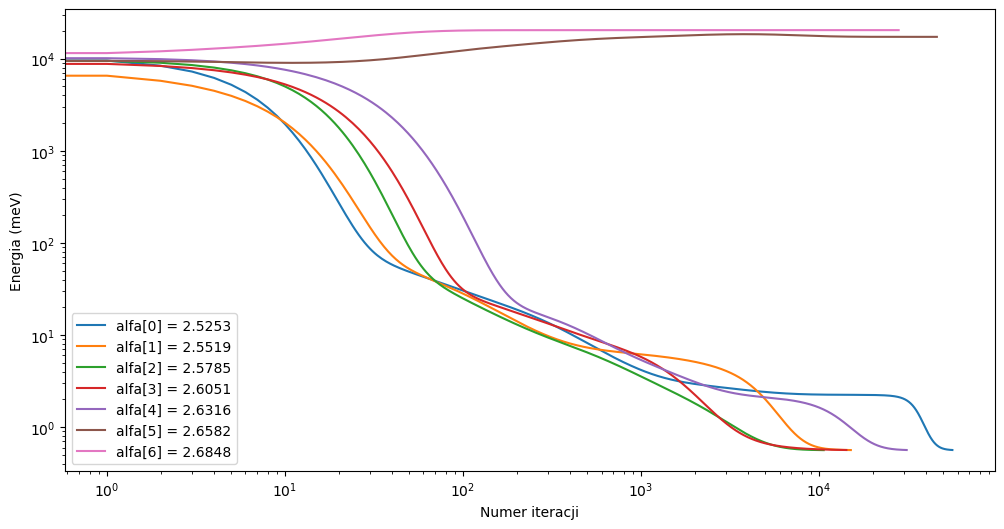

In [5]:
limit = m * dx**2 / h_bar**2
alfa = np.linspace(0.95 * limit, 1.01 * limit, 7)
V = np.zeros(N+1)

psi1 = np.zeros(N+1)
psi2 = RandomPsi(N+1)
h_psi = np.zeros(N+1)
Energies = []

plt.figure(figsize = (12,6))

psi2_values = []

for i in range(len(alfa)):
    j = 0
    while True:
        psi2 = IterPsi(psi1,psi2, V, alfa[i])
        psi2 = NormPsi(psi2)
        h_psi = HPsiArr(psi2,V)
        E = ExpE(psi2, h_psi)
        Energies.append(E)
        if i == 0:
            psi2_values.append(psi2.copy())
        if j > 4:
            if abs(Energies[j-1] - Energies[j-2]) < 1e-6/to_meV:
                break
        j = j + 1
    psi1 = np.zeros(N+1)
    psi2 = RandomPsi(N+1)

    
    plt.plot(range(len(Energies)), np.array(Energies) * to_meV, label=f'alfa[{i}] = {alfa[i]:.4f}')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Numer iteracji')
    plt.ylabel('Energia (meV)')
    #plt.title('Wartosc oczekiwana energii dla roznych parametrow alfa')
    Energies = []

# Zadanie 1.4

In [6]:
# Funkcja do obliczania funkcji ortogonalnej
@njit
def Excited(psi_2, psi_4):
    suma = np.sum(psi_2*psi_4*dx)
    psi_4 = psi_4 - suma * psi_2
    NormPsi(psi_4)
    return psi_4

In [7]:
len(psi2_values)

56121

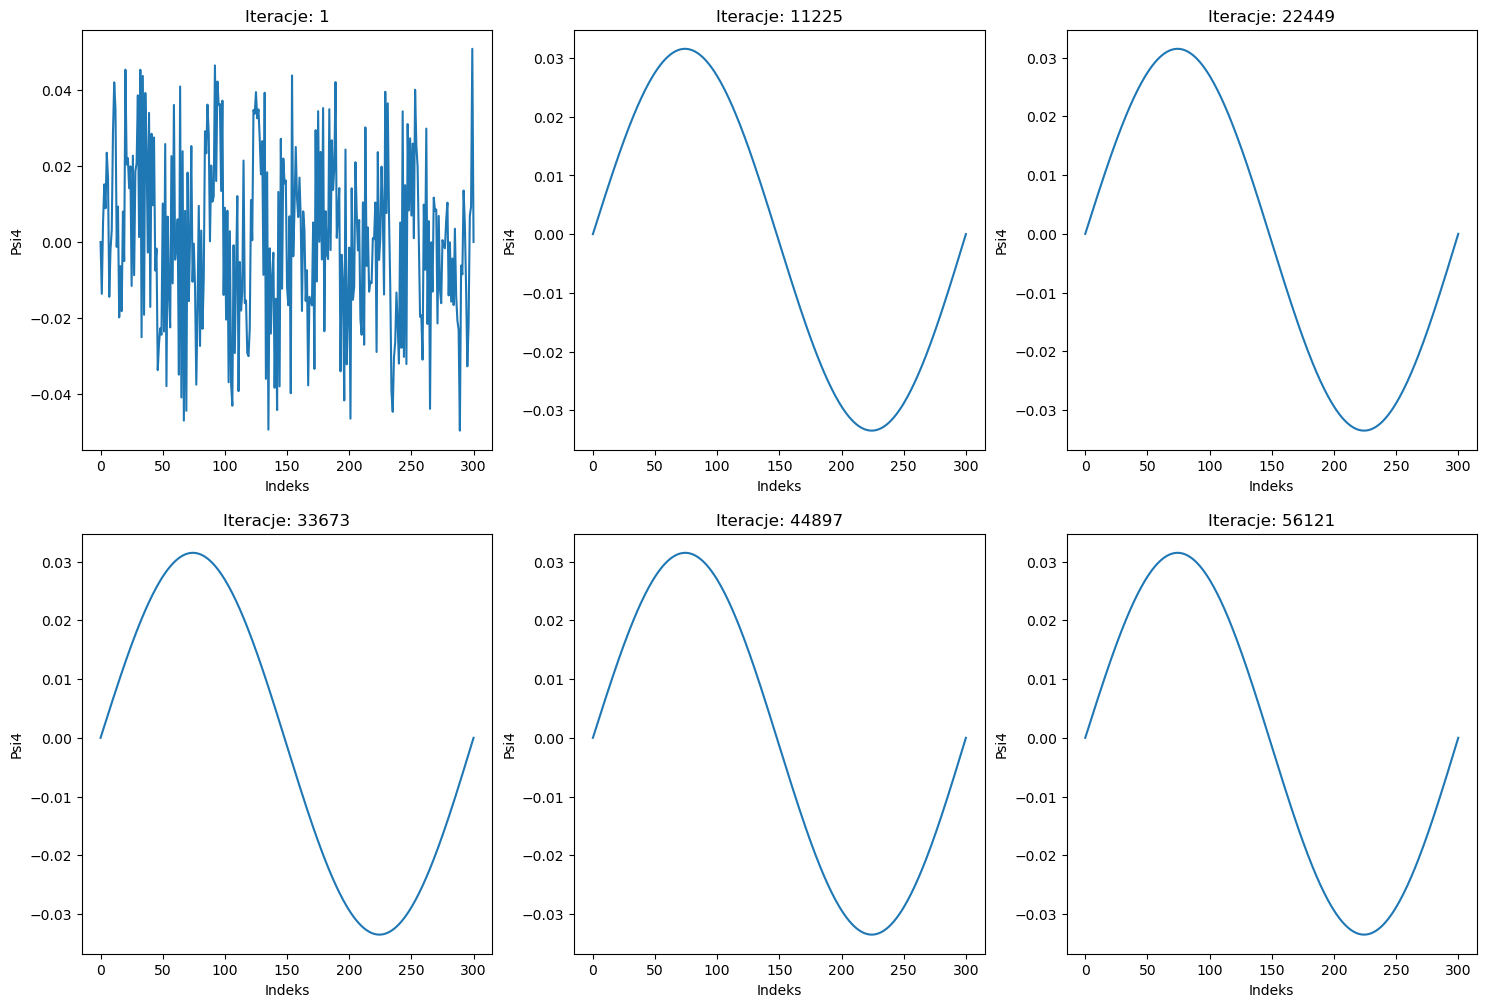

In [8]:
psi3 = np.zeros(N+1)
psi4 = RandomPsi(N+1)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
#fig.suptitle("Funkcje falowe psi4 w zależności od iteracji")

j = 0
row, col = 0, 0

# Dodajmy listę indeksów iteracji, które wyświetlimy
indices_to_plot = np.linspace(0, len(psi2_values) - 1, 6, dtype=int)
LEN1 = len(psi2_values)
while j < LEN1:
    psi4 = IterPsi(psi3, psi4, V, alfa[0])
    psi4 = NormPsi(psi4)
    psi4 = Excited(psi2_values[LEN1-1], psi4)

    h_psi = HPsiArr(psi4, V)
    E = ExpE(psi4, h_psi)
    Energies.append(E)
    
    # Wyświetl tylko iteracje, które znajdują się na liście indices_to_plot
    if j in indices_to_plot:
        if row < 2 and col < 3:
            ax = axs[row, col]
            ax.plot(range(N+1), psi4)
            ax.set_title(f"Iteracje: {j+1}")
            ax.set_xlabel("Indeks")
            ax.set_ylabel("Psi4")

            col += 1
            if col == 3:
                col = 0
                row += 1

    j = j + 1

# Usuń puste subploty, jeśli liczba iteracji nie jest podzielna przez 3
if j % 3 != 0:
    for i in range(j // 1000 + 1, 2):
        for j in range(3):
            fig.delaxes(axs[i, j])

plt.show()


In [9]:
# psi1 = np.zeros(N+1)
# psi2 = RandomPsi(N+1)
# psi3 = np.zeros(N+1)
# psi4 = RandomPsi(N+1)

# fig, axs = plt.subplots(2, 3, figsize=(18, 12))
# #fig.suptitle("Funkcje falowe psi4 w zależności od iteracji")

# j = 0
# row, col = 0, 0

# while True:
#     psi2 = IterPsi(psi1, psi2, V, alfa[0])
#     psi2 = NormPsi(psi2)
#     psi4 = IterPsi(psi3, psi4, V, alfa[0])
#     psi4 = NormPsi(psi4)
#     psi4 = Excited(psi2, psi4)

#     h_psi = HPsiArr(psi4, V)
#     E = ExpE(psi4, h_psi)
#     Energies.append(E)
    
#     if j % 1000 == 0:
#         if j > 4:
#             if abs(Energies[j-1] - Energies[j-2]) < 1e-6/to_meV:
#                 break

#         if row < 2 and col < 3:
#             ax = axs[row, col]
#             ax.plot(range(N+1), psi4)
#             ax.set_title(f"Iteracje: {j+1}")
#             ax.set_xlabel("Indeks")
#             ax.set_ylabel("Psi4")

#             col += 1
#             if col == 3:
#                 col = 0
#                 row += 1

#     j = j + 1

# # Usuń puste subploty, jeśli liczba iteracji nie jest podzielna przez 3
# if j % 3 != 0:
#     for i in range(j // 1000 + 1, 2):
#         for j in range(3):
#             fig.delaxes(axs[i, j])

# plt.show()

In [10]:
# psi1 = np.zeros(N+1)
# psi2 = RandomPsi(N+1)
# h_psi = np.zeros(N+1)
# Energies = []

# plt.figure(figsize=(12, 6))

# for i in range(len(alfa)):
#     j = 0
#     while True:
#         psi2 = IterPsi(psi1, psi2, V, alfa[i])
#         psi2 = NormPsi(psi2)
#         h_psi = HPsiArr(psi2, V)
#         E = ExpE(psi2, h_psi)
#         Energies.append(E)

#         if j > 4:
#             if abs(Energies[j-1] - Energies[j-2]) < 1e-6/to_meV:
#                 break

#         j += 1
#     psi1 = np.zeros(N+1)
#     psi2 = RandomPsi(N+1)


#     plt.plot(range(len(Energies)), np.array(Energies) * to_meV, label=f'alfa[{i}] = {alfa[i]:.4f}')
#     plt.legend()
#     plt.yscale('log')
#     plt.xscale('log')
#     #plt.title('Wartosc oczekiwana energii dla roznych parametrow alfa')
#     Energies = []

# plt.show()

# Zadanie 1.5

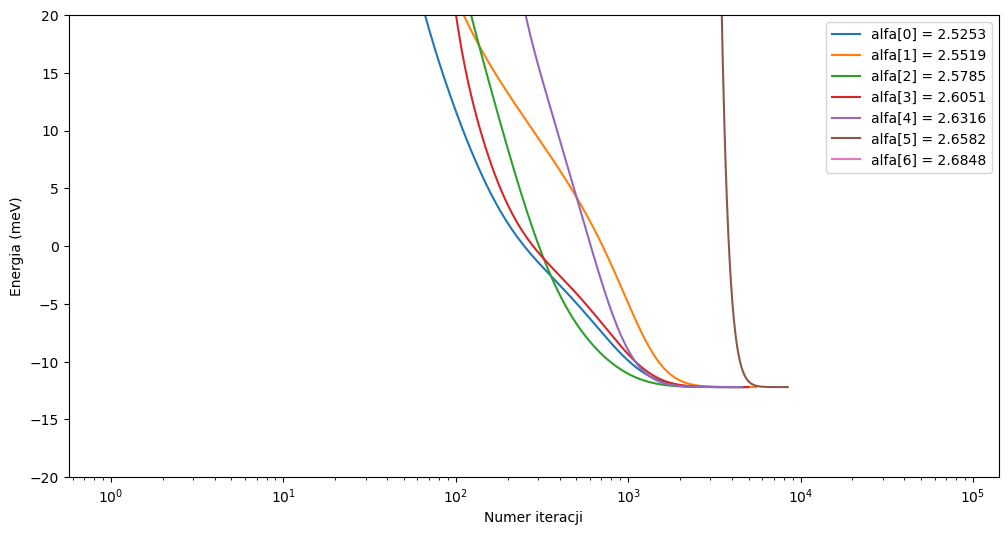

In [11]:
import numpy as np
import matplotlib.pyplot as plt

alfa = np.linspace(0.95 * m * dx**2 / h_bar**2, 1.01 * m * dx**2 / h_bar**2, 7)

psi1 = np.zeros(N+1)
psi2 = RandomPsi(N+1)
h_psi = np.zeros(N+1)
Energies = []

W = np.zeros(N+1)
W[N//2] = -500/to_meV

psi2_values_W = []

plt.figure(figsize=(12, 6))

for i in range(len(alfa)):
    j = 0
    while True:
        psi2 = IterPsi(psi1, psi2, W, alfa[i])
        psi2 = NormPsi(psi2)
        h_psi = HPsiArr(psi2, W)
        E = ExpE(psi2, h_psi)
        Energies.append(E)
        if i == 0:
            psi2_values_W.append(psi2.copy())
        if j > 4:
            if abs(Energies[j-1] - Energies[j-2]) < 1e-7/to_meV:
                break

        j += 1
    psi1 = np.zeros(N+1)
    psi2 = RandomPsi(N+1)


    plt.plot(range(len(Energies)), np.array(Energies) * to_meV, label=f'alfa[{i}] = {alfa[i]:.4f}')
    plt.legend()
    plt.ylim(-20, 20)
    plt.xscale('log')
    plt.xlabel('Numer iteracji')
    plt.ylabel('Energia (meV)')
    #plt.title('Wartosc oczekiwana energii dla roznych parametrow alfa, gdzie W = 500 meV')
    Energies = []

plt.show()

In [12]:
len(psi2_values_W)

4955

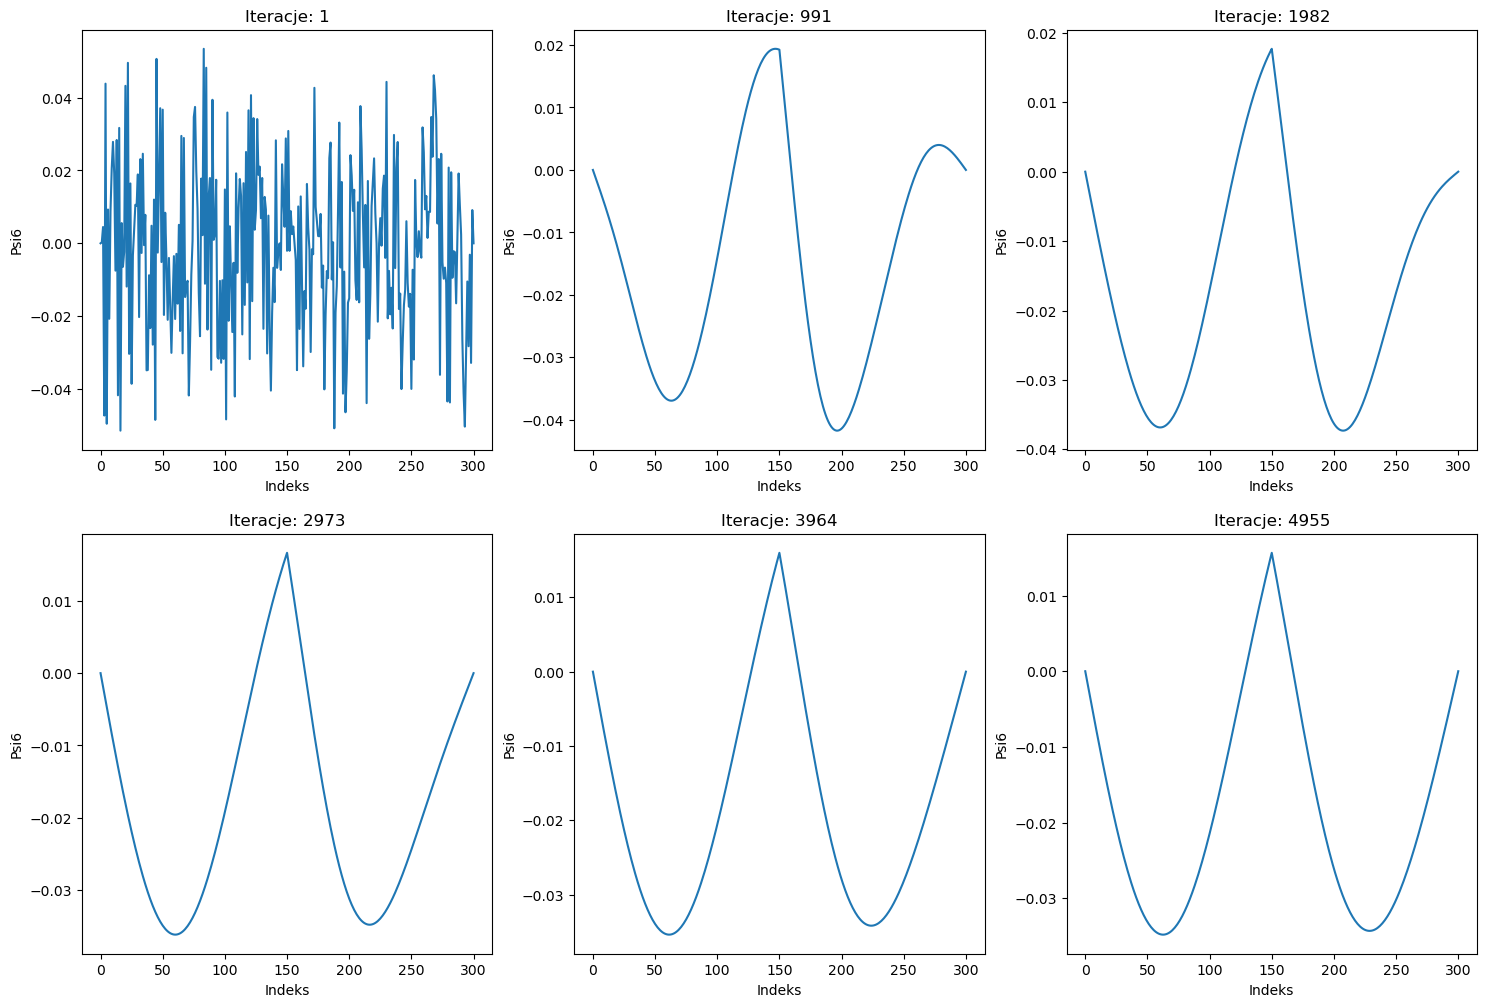

In [13]:
psi5 = np.zeros(N+1)
psi6 = RandomPsi(N+1)

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
#fig.suptitle("Funkcje falowe psi4 w zależności od iteracji")

j = 0
row, col = 0, 0

# Dodajmy listę indeksów iteracji, które wyświetlimy
indices_to_plot = np.linspace(0, len(psi2_values_W) - 1, 6, dtype=int)
LEN2 = len(psi2_values_W)
while j < LEN2:
    psi6 = IterPsi(psi5, psi6, W, alfa[0])
    psi6 = NormPsi(psi6)
    psi6 = Excited(psi2_values_W[LEN2-1], psi6)

    h_psi = HPsiArr(psi6, W)
    E = ExpE(psi6, h_psi)
    Energies.append(E)
    
    # Wyświetl tylko iteracje, które znajdują się na liście indices_to_plot
    if j in indices_to_plot:
        if row < 2 and col < 3:
            ax = axs[row, col]
            ax.plot(range(N+1), psi6)
            ax.set_title(f"Iteracje: {j+1}")
            ax.set_xlabel("Indeks")
            ax.set_ylabel("Psi6")

            col += 1
            if col == 3:
                col = 0
                row += 1

    j = j + 1

# Usuń puste subploty, jeśli liczba iteracji nie jest podzielna przez 3
if j % 3 != 0:
    for i in range(j // 1000 + 1, 2):
        for j in range(3):
            fig.delaxes(axs[i, j])

plt.show()
